## Dynamic Time Warping

In [1]:
import warnings
warnings.filterwarnings("ignore")

from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as dist
from pandas_datareader import data as pdr
import yfinance as yfin
import tslearn
from dtw.utils import *

#### Test on BTC/USD and ETH/USD time series

In [2]:
# Download data sample
tickers = ["BTC-USD", "ETH-USD", "GOOG", "MSFT"]
start_date = "2018-01-01"
end_date = "2022-12-31"

yfin.pdr_override()

btc_data = pdr.get_data_yahoo(tickers[0],  start=start_date, end=end_date, interval = "1wk")
eth_data = pdr.get_data_yahoo(tickers[1],  start=start_date, end=end_date, interval = "1wk")
goog_data = pdr.get_data_yahoo(tickers[2],  start=start_date, end=end_date, interval = "1wk")
msft_data = pdr.get_data_yahoo(tickers[3],  start=start_date, end=end_date, interval = "1wk")

# Save close data
btc_close = btc_data['Close']
eth_close = eth_data['Close']
goog_close = goog_data['Close']
msft_close = msft_data['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


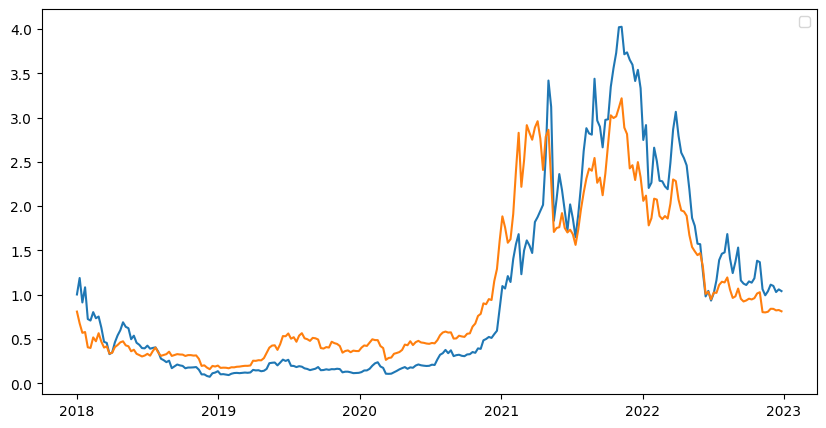

In [3]:
#Visualize time series
%matplotlib inline

btc_normalized_close = btc_data['Close']/btc_data['Close'].mean()
eth_normalized_close = eth_data['Close']/eth_data['Close'].mean()

X = np.array([btc_normalized_close.values,eth_normalized_close.values, msft_close.values, goog_close.values])


fig, ax = plt.subplots(figsize=(10,5))
ax.plot(eth_data.index, eth_normalized_close)
ax.plot(btc_data.index, btc_normalized_close)
ax.legend()

In [4]:
# Transform into array
x = btc_normalized_close.values
y = eth_normalized_close.values

# Build local distance Matrix
N = x.shape[0]
M = y.shape[0]
dist_mat = np.zeros((N,M))
for i in range(N):
    for j in range(M):
        dist_mat[i,j] = abs(x[i]-y[j])

Alignment cost: 35.7012
Normalized alignment cost: 0.0684


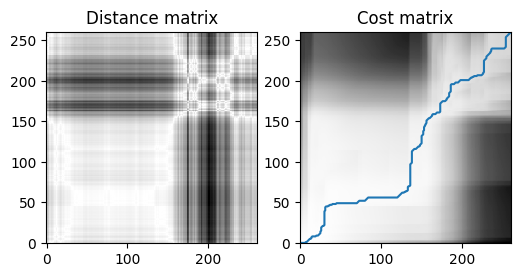

In [5]:
path, cost_mat = dp(dist_mat)
print("Alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]))
print("Normalized alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]/(N + M)))

plt.figure(figsize=(6, 4))
plt.subplot(121)
plt.title("Distance matrix")
plt.imshow(dist_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
plt.subplot(122)
plt.title("Cost matrix")
plt.imshow(cost_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_path, y_path = zip(*path)
plt.plot(y_path, x_path)

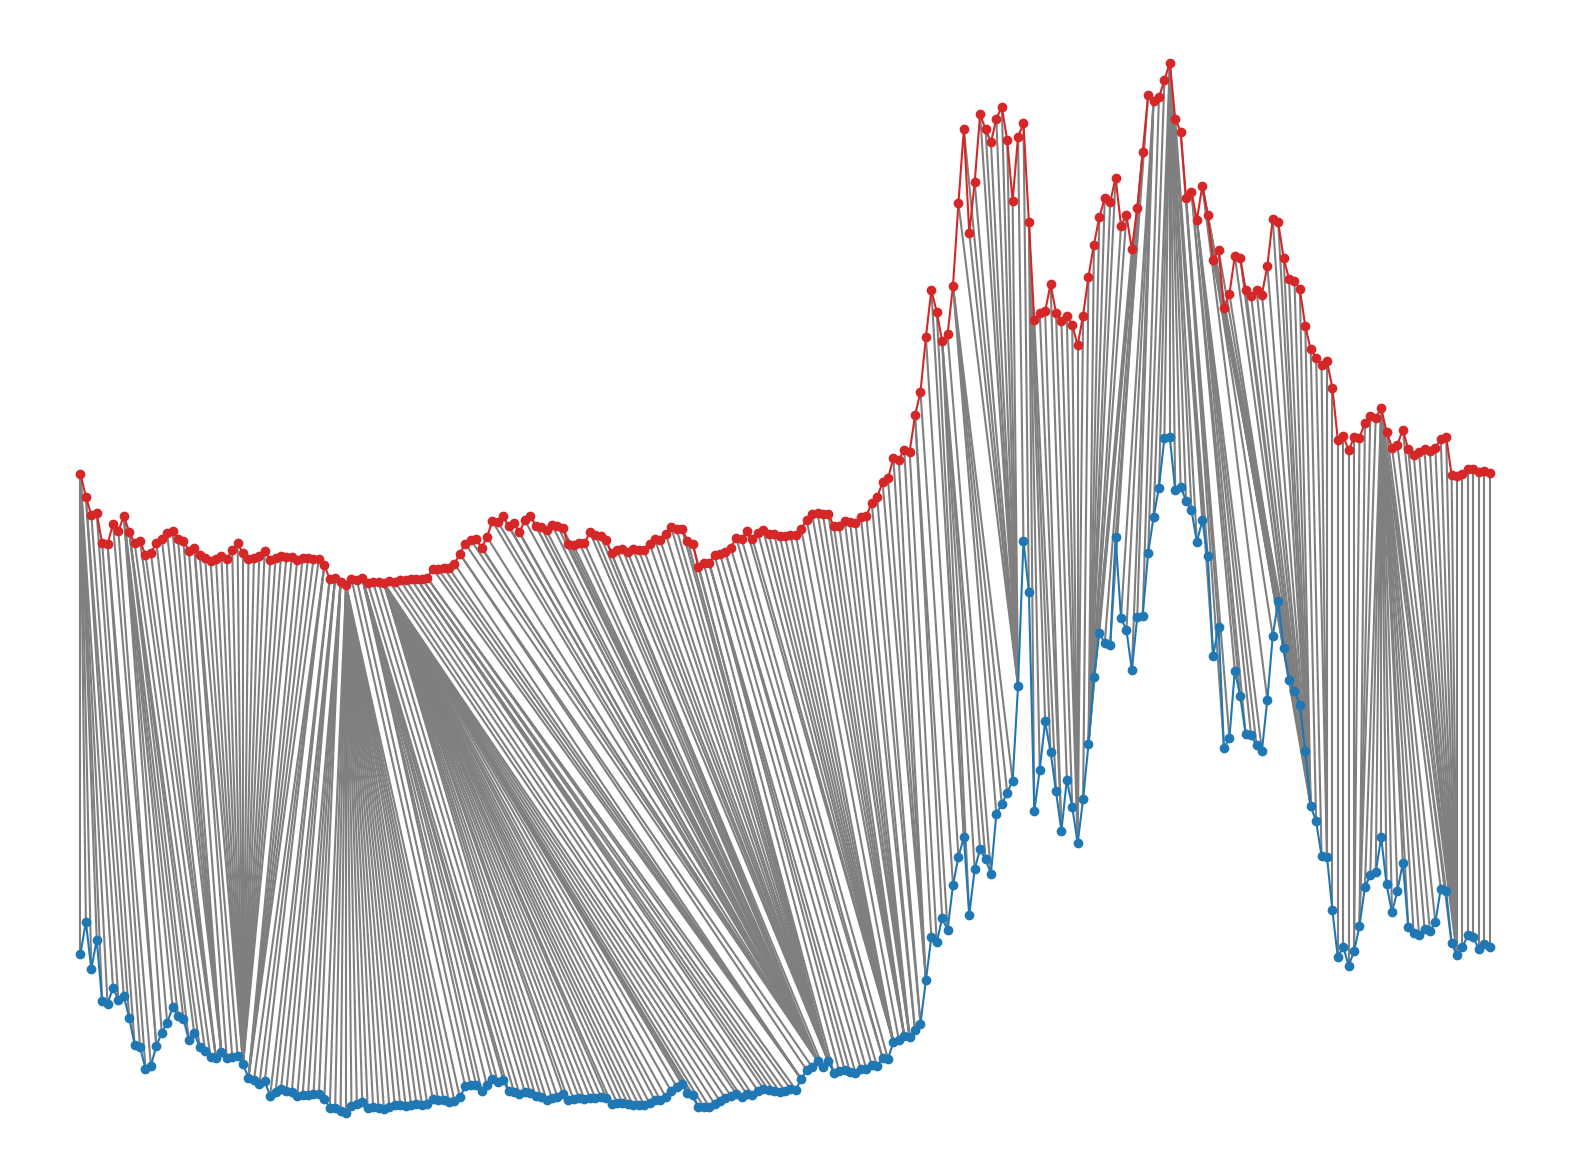

In [6]:
plt.figure(figsize=(20,15))
for x_i, y_j in path:
    plt.plot([x_i, y_j], [x[x_i] + 1.5, y[y_j] - 1.5], c="C7")
plt.plot(np.arange(x.shape[0]), x + 1.5, "-o", c="C3")
plt.plot(np.arange(y.shape[0]), y - 1.5, "-o", c="C0")
plt.axis("off")
plt.savefig("../fig/Simple_DTW.pdf")

 The plot shows how Dynamic Time Warping without constraints produce results inconsistent with a visual analysis. It looks like the warping tends to produce too many "singularities" (a.k.a. one point of one series is mapped into many of the other). It is therefore necessary to test for variations of the algorithm and check their performance.

 Another option is to change the step patterns. Given the amount of data, even at the week level, only looking at three neighbouring elements of the local cost matrix may not be a good strategy to search for the most efficient cost path. It is important to keep in mind that such search algorithm is only one of the possible dynamic programming methods one can use the determine the path. It might be interesting to evaluate some sort of grid search or optimized tree search and at most even a reinforcement learning algorithm to find such optimum path more efficiently. 

### Path Kernel Variant

Alignment cost: 44.9400
Normalized alignment cost: 0.0861


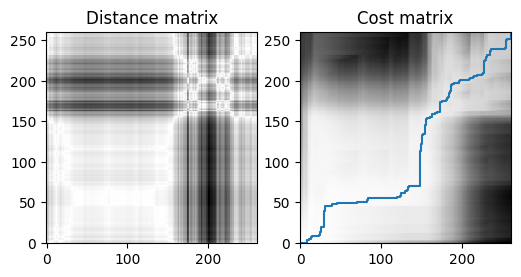

In [7]:
path, cost_mat = dp(dist_mat, hv_cost = 1, d_cost=1.5)
print("Alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]))
print("Normalized alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]/(N + M)))

plt.figure(figsize=(6, 4))
plt.subplot(121)
plt.title("Distance matrix")
plt.imshow(dist_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
plt.subplot(122)
plt.title("Cost matrix")
plt.imshow(cost_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_path, y_path = zip(*path)
plt.plot(y_path, x_path)

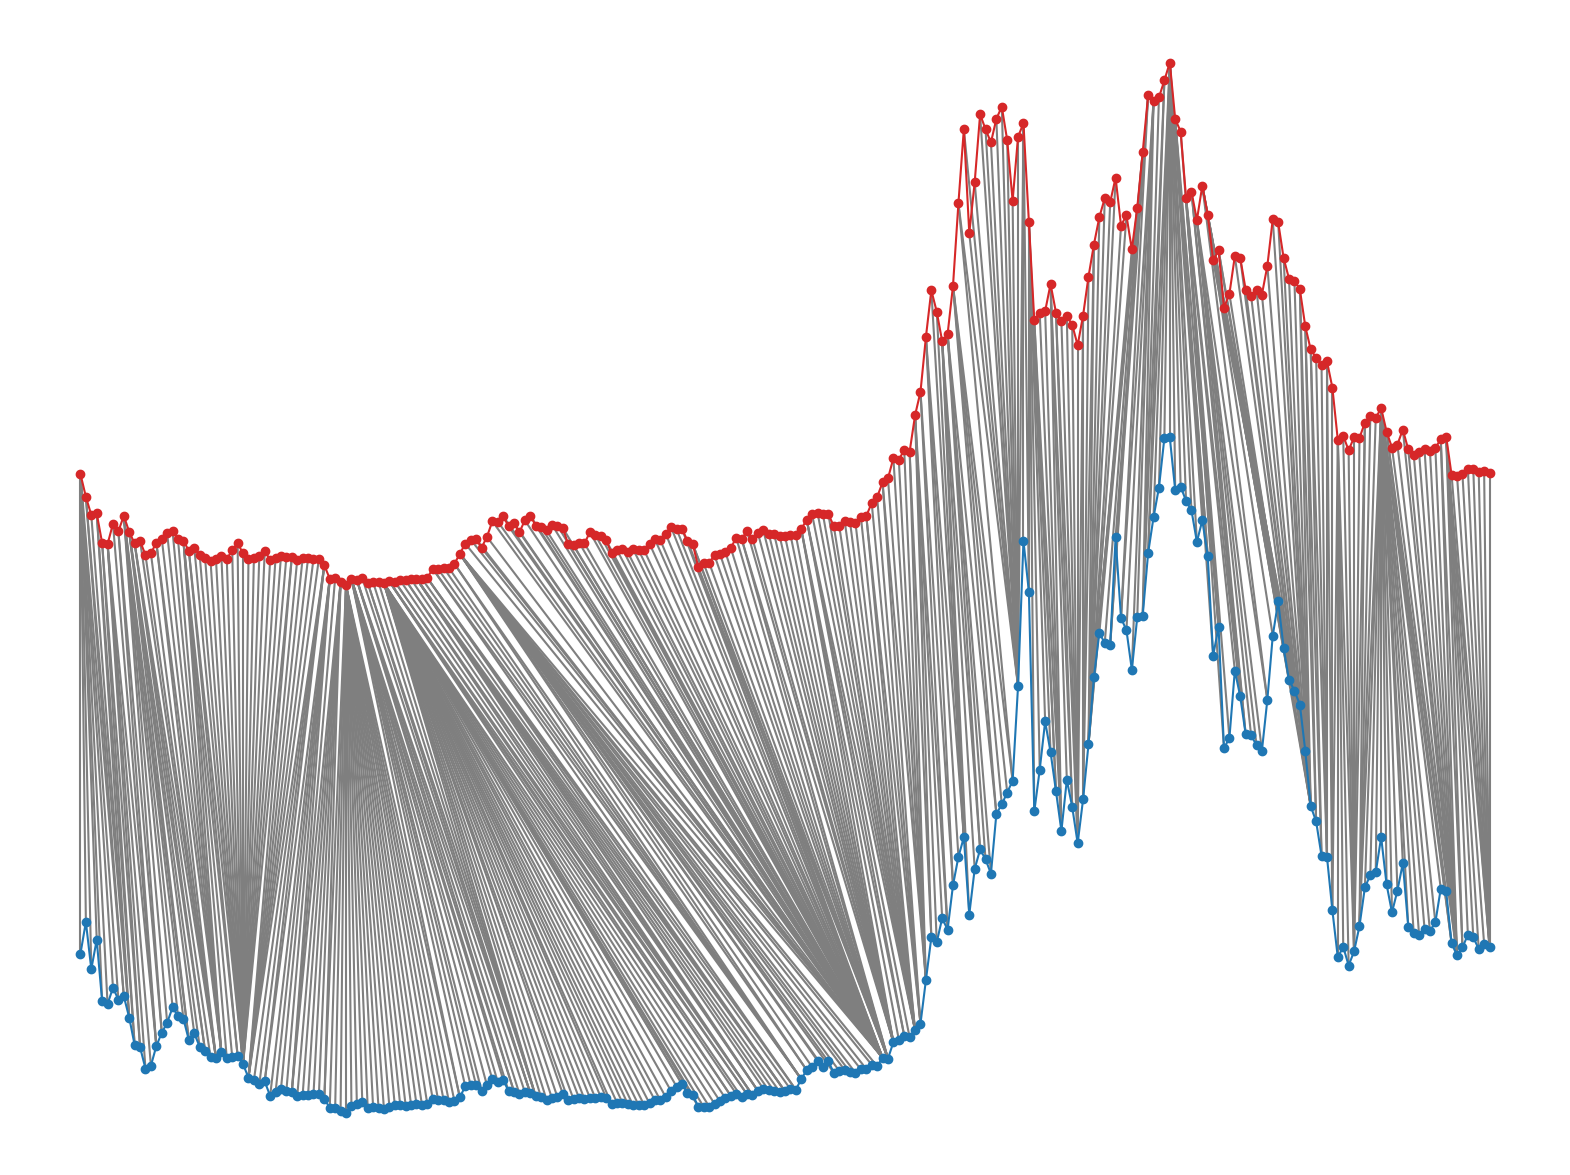

In [8]:
plt.figure(figsize=(20,15))
for x_i, y_j in path:
    plt.plot([x_i, y_j], [x[x_i] + 1.5, y[y_j] - 1.5], c="C7")
plt.plot(np.arange(x.shape[0]), x + 1.5, "-o", c="C3")
plt.plot(np.arange(y.shape[0]), y - 1.5, "-o", c="C0")
plt.axis("off")
plt.savefig("../fig/Path_Kernel_DTW.pdf")

### Slope Constraint

Alignment cost: 68.8594
Normalized alignment cost: 0.1319


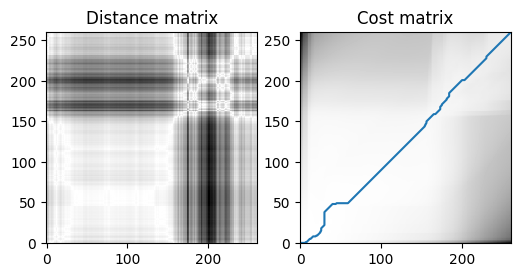

In [9]:
path, cost_mat = dp(dist_mat, hv_cost = 1.0103)
print("Alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]))
print("Normalized alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]/(N + M)))

plt.figure(figsize=(6, 4))
plt.subplot(121)
plt.title("Distance matrix")
plt.imshow(dist_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
plt.subplot(122)
plt.title("Cost matrix")
plt.imshow(cost_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_path, y_path = zip(*path)
plt.plot(y_path, x_path)

The figure below shows a plot of the value of normalized alignment cost against a range of increasing slope values. The situation tends to only deteriorate, even though the result is a reduction in singularities that must in some way be balanced with the increased cost

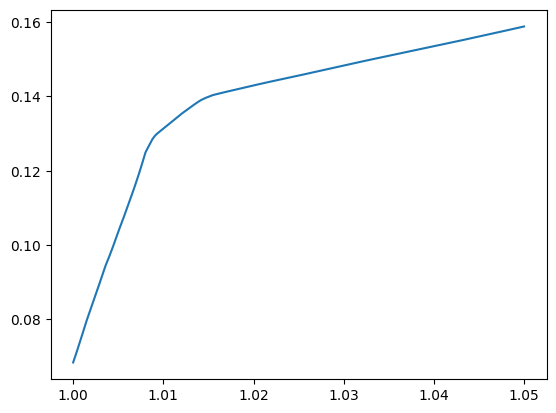

In [11]:
normalized_cost = np.array([dp(dist_mat, i)[1][N - 1, M - 1]/(N + M) for i in np.arange(1,1.05, 0.0001)])
# normalized_cost = cost_mat[N - 1, M - 1]/(N + M)
plt.plot(np.arange(1,1.05, 0.0001), normalized_cost)

In [ ]:
plt.figure(figsize=(20,15))
for x_i, y_j in path:
    plt.plot([x_i, y_j], [x[x_i] + 1.5, y[y_j] - 1.5], c="C7")
plt.plot(np.arange(x.shape[0]), x + 1.5, "-o", c="C3")
plt.plot(np.arange(y.shape[0]), y - 1.5, "-o", c="C0")
plt.axis("off")
#plt.savefig("../fig/Slope_Constraint_DTW.pdf")